In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import datetime

In [2]:
def parser(x):
    return datetime.strptime(x,'%Y-%m-%d')

In [3]:
df=pd.read_csv('prepared_individual_data/Acidity.csv',index_col=0,parse_dates=[0],date_parser=parser)

/home/manjit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


In [4]:
df.head()

,Acidity
Date,
2018-06-01,0
2018-06-02,0
2018-06-03,0
2018-06-04,0
2018-06-05,0


In [5]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

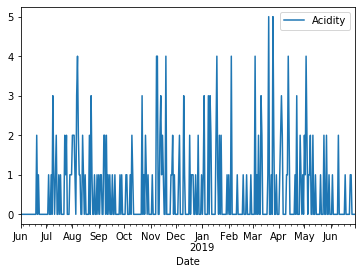

In [6]:
df.plot()

In [7]:
df_urti_weeklyS = df.resample('W').sum()
df_urti_weeklyM = df.resample('W').mean()

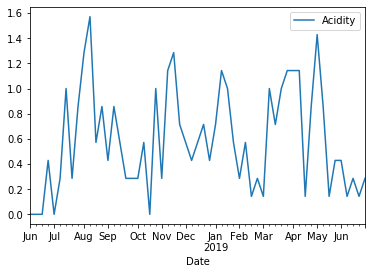

In [8]:
df_urti_weeklyM.plot()

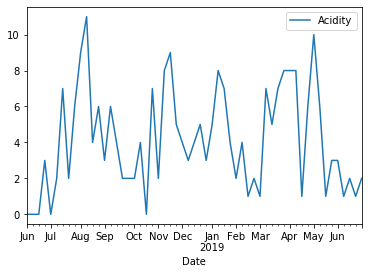

In [9]:
df_urti_weeklyS.plot()

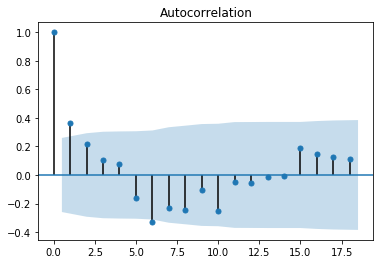

In [10]:
plot_acf(df_urti_weeklyM);

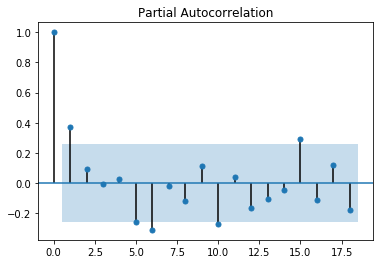

In [11]:
plot_pacf(df_urti_weeklyM);

# ARMA on weekly data

In [12]:
df_weekly=df_urti_weeklyM.diff(1)[1:]

In [13]:
df_weekly.head()

,Acidity
Date,
2018-06-10,0.000000
2018-06-17,0.000000
2018-06-24,0.428571
2018-07-01,-0.428571
2018-07-08,0.285714


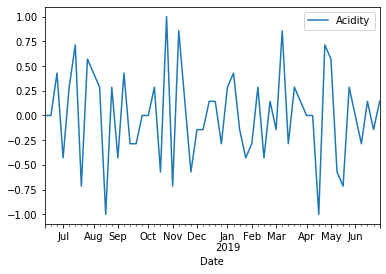

In [14]:
df_weekly.plot()

In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
X=df_weekly['Acidity'].values
result=adfuller(X)
print("ADF Statistic: %f" % result[0])
print("p-value:  %f" % result[1])
print('Critical values: ')
for key,value in result[4].items():
    print("\t%s: %.3f" % (key,value))
if result[0] < result[4]["5%"]:
    print("Reject Ho - Time Series is stationary")
else:
    print("Failed to reject Ho - Time Series is not stationary")

ADF Statistic: -11.082368
p-value:  0.000000
Critical values: 
	1%: -3.555
	5%: -2.916
	10%: -2.596
Reject Ho - Time Series is stationary


In [17]:
df_weekly.size

56

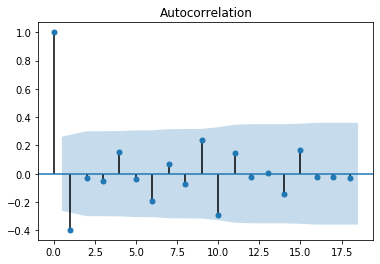

In [18]:
plot_acf(df_weekly);

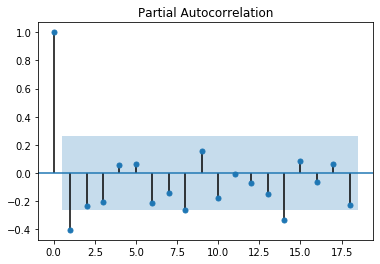

In [19]:
plot_pacf(df_weekly);

In [20]:
total=df_weekly
test_size=int(0.20*total.size)
train_size=total.size-test_size

In [21]:
test_size

11

In [22]:
train_size

45

In [23]:
total.size

56

In [24]:
train=total[:train_size]

In [25]:
test=total[train_size:]

In [26]:
train.size+test.size

56

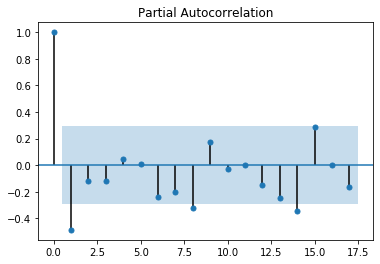

In [27]:
plot_pacf(train);

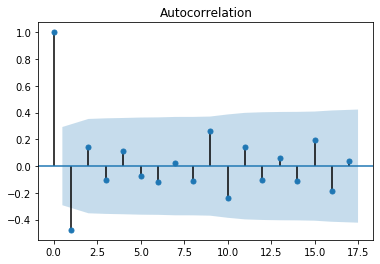

In [28]:
plot_acf(train);

In [29]:
from statsmodels.tsa.arima_model import ARMA

In [30]:
arma_model=ARMA(train,order=(15,3))
arma_model_fit=arma_model.fit()

In [31]:
arma_preds=arma_model_fit.predict(start=(train_size),end=(total.size-1))

In [32]:
arma_preds.size

11

In [33]:
arma_preds

2019-04-21   -0.541721
2019-04-28    0.293966
2019-05-05   -0.227376
2019-05-12   -0.120475
2019-05-19   -0.240927
2019-05-26    0.350912
2019-06-02   -0.162872
2019-06-09   -0.075883
2019-06-16    0.103415
2019-06-23    0.173077
2019-06-30    0.120748
Freq: W-SUN, dtype: float64

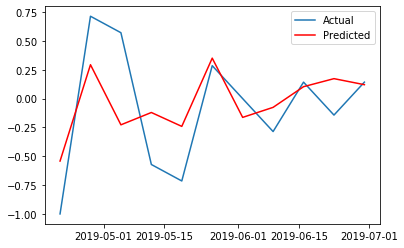

In [34]:
plt.plot(test,label='Actual')
plt.plot(arma_preds,color='red',label='Predicted')
plt.legend()

In [35]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acs

In [36]:
mse(y_true=test,y_pred=arma_preds)

0.1480792212743975

In [37]:
pred_values=arma_preds.values
test_values=test.values

In [38]:
import pickle
from pickle_class_info import SerializableData
obj=SerializableData(train,arma_model_fit,'acidity')

In [39]:
f=open('model_'+obj.label,'wb')
pickle.dump(obj,f)
f.close()